# Quantum adder 

### Based on QUANTUM ARITHMETIC OPERATIONS BASED ON QUANTUM FOURIER TRANSFORM ON SIGNED INTEGERS
https://arxiv.org/pdf/2005.00443.pdf

In [67]:
from qiskit import Aer, transpile, QuantumCircuit
from qiskit.circuit.library import QFT
from qiskit.tools.visualization import plot_histogram
import numpy as np

In [70]:
a = 2
b = 2

bin_a = bin(a)[2:].zfill(3)
bin_b = bin(b)[2:].zfill(2)
print(bin_a)
print(bin_b)

num_qubits = len(bin_a) + len(bin_b) + 1

def pre_treatment(bin_a, bin_b):
    encoding_circuit = QuantumCircuit(num_qubits - 1, name="Encode")
    for i, b in enumerate(reversed(bin_a)):
        if int(b) == 1:
            encoding_circuit.x(i)
    for i, b in enumerate(bin_b):
        if int(b) == 1:
            encoding_circuit.x(len(bin_a) + i)
    return encoding_circuit

010
10


In [81]:
encoding_circuit = pre_treatment(bin_a, bin_b)
qft = QFT(num_qubits=len(bin_a) + 1).to_gate()

encoding_circuit.draw()

q_0: ─────
     ┌───┐
q_1: ┤ X ├
     └───┘
q_2: ─────
     ┌───┐
q_3: ┤ X ├
     └───┘
q_4: ─────

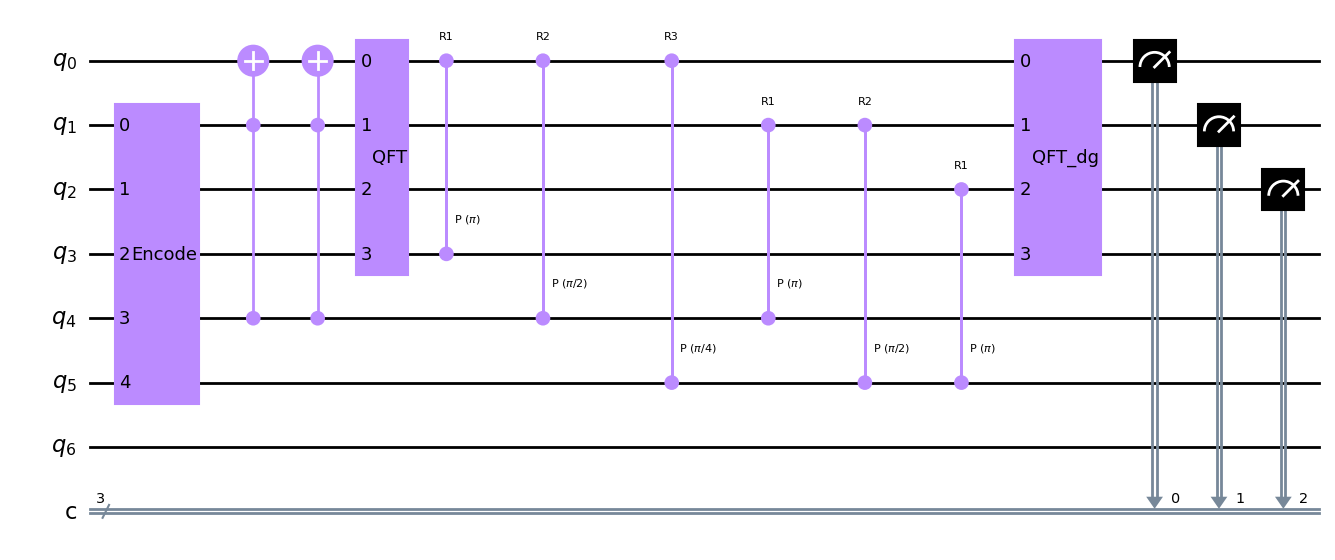

In [83]:
# Create a quantum circuit with the number of bits we need to represent our binary integers to add
circ = QuantumCircuit(num_qubits + 1, len(bin_a))

# Encode the integer into binary
circ.append(encoding_circuit, [i for i in range(1, num_qubits)])

circ.toffoli(1 + len(bin_a), 1, 0)
circ.toffoli(1, 1 + len(bin_a), 0)

# Apply QFT to second number
circ.append(qft, [i for i in range(len(bin_a) + 1)])

for i in range(len(bin_a)):
    for k, j in enumerate(range(i + len(bin_a), num_qubits)):
        circ.cp(theta = 2 * np.pi / 2 ** (k + 1), control_qubit=i, target_qubit=k + len(bin_a) + i, label=f"R{k+1}")

circ.append(qft.inverse(), [i for i in range(len(bin_a) + 1)])

circ.measure([i for i in range(len(bin_a))], [i for i in range(len(bin_a))])
circ.draw('mpl')

In [50]:
backend = Aer.get_backend('aer_simulator_statevector')
circ = transpile(circ, backend)

In [51]:
result = backend.run(circ).result().get_counts(circ)
print(result)

{'0010': 1024}


In [52]:
plot_histogram(result.get_counts(circ))

AttributeError: 'Counts' object has no attribute 'get_counts'